<!--HEADER-->
*Tutorial sobre Flux.jl - 2020/2 [- Ricardo M. S. Rosa (IM/UFRJ)](http://www.im.ufrj.br/rrosa)*

<!--BADGES-->
<a href="https://nbviewer.jupyter.org/github/rmsrosa/TutorialFlux/blob/main/notebooks/06.00-Metodos_treinamento.ipynb" target="_blank"><img align="left" src="https://img.shields.io/badge/view%20in-nbviewer-orange" alt="View in NBViewer" title="View in NBViewer"></a><a href="https://mybinder.org/v2/gh/rmsrosa/TutorialFlux/julia-env-for-binder?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Frmsrosa%252FTutorialFlux%26branch%3Dmain%26urlpath%3Dtree%252FTutorialFlux%252Fnotebooks/06.00-Metodos_treinamento.ipynb" target="_blank"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open in binder"></a><a href="https://nbviewer.jupyter.org/github/rmsrosa/TutorialFlux/blob/main/notebooks/slides/06.00-Metodos_treinamento.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/view-slides-darkgreen" alt="View Slides" title="View Slides"></a>&nbsp;

<!--NAVIGATOR-->
[<- 5. Treinando redes neurais](05.00-Treinando_redes_neurais.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [7. Identificação de dígitos com os dados MNIST ->](07.00-Reconhecimento_digitos.ipynb)

---


# Métodos de treinamento

* O que o `Flux.train!` faz é apenas executar um passo de um dado algoritmo de otimização.

* Vamos ver detalhes do `Flux.train!`.

* Assim como as opções de algoritmos.

In [1]:
using Flux
using Random
using Plots

## `Flux.train!`

* O `Flux.train!` é parte do módulo [Flux.Optimise](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/Optimise.jl).

* Vejamos o [código do `Flux.train!`](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/train.jl#L96):

```julia
function train!(loss, ps, data, opt; cb = () -> ())
  ps = Params(ps)
  cb = runall(cb)
  @progress for d in data
    try
      gs = gradient(ps) do
        loss(batchmemaybe(d)...)
      end
      update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa StopException
        break
      elseif ex isa SkipException
        continue
      else
        rethrow(ex)
      end
    end
  end
end
```

### Detalhes

* [Params](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L67) e [gradient](https://github.com/FluxML/Zygote.jl/blob/master/src/compiler/interface.jl#L57) são importados do [FluxML/Zygote.jl](https://github.com/FluxML/Zygote.jl), que é um pacote de **diferenciação automática**.

* `Params` é um tipo composto que guarda quais parâmetros e em que ordem devemos diferenciar uma função

* `params`, utilizado no treinamento visto anteriormente, define quais parâmetros serão considerados para a diferenciação.

* `gradient` calcula o gradiente de uma função, em relação aos parâmetros dados, via diferenciação automática.

* `gradient` usa `backwards propagation` (veja o uso de `pullback(f, args...)` na sua definição).

* **Observação:** Podemos "pular" o `Flux.train!` e escrever métodos de otimização com outros métodos de diferenciação, como `ForwardDiff` (forwards propagation) e `ReverseDiff` (backward mas mais genérico e não tão eficiente quando o `gradient` no caso de redes neurais em questão). Leia mais sobre isso e sobre outros pacotes em [JuliaDiff](https://juliadiff.org).

### Atalho para uma sequência de treinos

* É comum vermos o uso de 

```julia
@epochs N train!(...)
```

* Isso é apenas um atalho para um loop com a exibição de época a cada iteração:

```julia
for i=1:N
    train!(...)
end
```

### Callbacks

* O parâmetro de `callback` pode ser muito útil para
    * exibir informações sobre um *loop* de treinamento
    * afetar o treinamento de alguma forma
        * interromper quando um determinada acurácia é alcançada;
        * interromper quando um limite de iterações o de tempo é alcançado;
        * trocar os parâmetros correntes de busca caso o treinamente não esteja indo com muito sucesso;
        * substituir, acrescentar ou retirar determinados parâmetros do processo de treinamento;
        * validar o treinamento de acordo com outra amostra de dados;
        * etc.

* Vale lembrar que `callbacks` estão presentes em outros pacotes também, como `DifferentialEquations`, etc., para executar alguma instrução no meio de algum outro processo (e.g. resolução de uma EDO).

* O *Callback* é uma *keyword*, ou seja, é preciso passar como `cb = funcao_de_callback`, exceto que, no Julia 1.6, se a própria função tiver o nome da *keyword*, i.e. `cb`, no caso, então podemos passá-la direto como `Flux.train!(loss, ps, data, opt; cb)`.

* Veja mais em [Callback Helpers](https://fluxml.ai/Flux.jl/stable/utilities/#Callback-Helpers-1).

## Inicialização das camadas

* A inicialização das camadas é um ponto importante do processo.

* Isso é particularmente importante em camadas convolucioais ou recorrentes.

* Por *default*, `Flux.jl` inicializa essas camadas com o método `Flux.glorot_uniform`.

* Outros métodos estão disponíveis: `glorot_normal`, `kalman_uniform`, `kalman_normal`.

* Mais sobre isso em [Layer Initialization](https://fluxml.ai/Flux.jl/stable/utilities/#Layer-Initialization-1).

## Métodos de otimização

* Uma das opções, em `Flux.train!(loss, ps, data, opt, cb)` é o método de otimização `opt`.

* Não há opção *default* para o método de otimização. É preciso escolher um.

* Há várias opções.

* Todos os métodos estão implementados como diferentes "despachos" da função `Flux.Optimise.apply!`, em [src/optimise/optimisers.jl](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/optimisers.jl).

* Essa função `apply!` é chamada no processo de atualização do passo, dentro da função [update!](https://github.com/FluxML/Flux.jl/blob/master/src/optimise/train.jl#L26), após o gradiente ter sido calculado. 

In [2]:
methods(Flux.Optimise.apply!)

# 19 methods for generic function "apply!":
[1] apply!(o::ClipNorm, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:666
[2] apply!(o::ClipValue, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:655
[3] apply!(o::AMSGrad, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:415
[4] apply!(o::RMSProp, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:139
[5] apply!(o::ADAGrad, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:346
[6] apply!(o::RADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:213
[7] apply!(o::ADADelta, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:377
[8] apply!(o::WeightDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:641
[9] apply!(o::ExpDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:617
[10] apply!(o::ADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:172
[11] apply!(o::AdaBelief, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:521
[12] apply!(o::Flux.Optimise.Optimiser, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:551
[13] apply!(o::Nesterov, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:102
[14] apply!(o::AdaMax, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:262
[15] apply!(o::InvDecay, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:577
[16] apply!(o::Descent, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:39
[17] apply!(o::NADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:455
[18] apply!(o::Momentum, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:69
[19] apply!(o::OADAM, x, Δ) in Flux.Optimise at /Users/rrosa/.julia/packages/Flux/qp1gc/src/optimise/optimisers.jl:304

## Treinando em lotes e o gradiente estocástico

* No caderno anterior, fizemos exemplos com passos "tradicionais", ou seja, levando-se em consideração todos os dados da amostra em cada "época".

* O método de gradiente estocástico utiliza apenas um dado da amostra em cada passo, escolhido aleatoriamente, completando uma "época" quando todos os dados são utilizados (no caso sem reposição) ou com algumas reutilizações e outros esquecios (no caso com reposição).

* E um caso intermediário é o **em lotes** *(batch)*, em que a amostra é dividida em grupos iguais escolhidos aleatoriamente e todos de um mesmo grupo são considerados a cada passo.

* Essa metodologia pode ser aplicada, na verdade, em conjunto com qualquer método de otimização, não apenas o de gradiente descendente.

* Para implementar isso, podemos fazer essa seleção manualmente ou usar a função 

### Exemplo

In [3]:
f(x) = 0.2*sin(4*π*x) + 0.3*exp(-x) + 4.0*x^6 - 3.5*x^5
data_x = reshape(collect(0:0.05:1), 1, :)
data_y = f.(data_x)
nothing

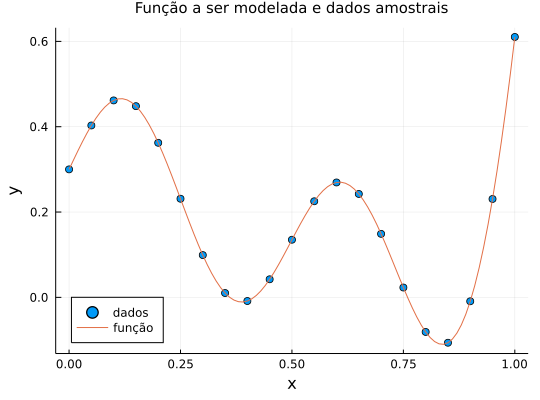

In [4]:
plot(data_x', data_y',
    seriestype=:scatter, size=(540,400), label="dados", legend=:bottomleft,
    xaxis = "x", yaxis = "y",
    title="Função a ser modelada e dados amostrais", titlefont=10)
plot!(0:0.01:1, f,
     size=(540,400), label="função")

### Preparando a rede e os dados

In [5]:
m = Chain(Dense(1, 4, σ), Dense(4,1))

Chain(Dense(1, 4, σ), Dense(4, 1))

In [6]:
m[1].weight[1:end] = [5.0, -5.0, -5.0, -5.0]
m[1].bias[1:end] = [-0.0, -0.0, 0.0, 0.0]
m[2].weight[1:end] = [5.0, -2.0, 5.0, -5.0]
m[2].bias[1:end] = [0.0]
nothing

### Preparando os dados

#### Para usar todos os dados de uma vez só, em cada época

In [7]:
data=[(data_x, data_y)]

1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.0 0.05 … 0.95 1.0], [0.3 0.4029248465587088 … 0.2305995378278558 0.6103638323514327])

#### Para usar um dado de cada vez, em cada época

In [8]:
data_single = reshape([([x],[y]) for (x,y) in zip(data_x,data_y)], :, 1)

21×1 Matrix{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0], [0.3])
 ([0.05], [0.4029248465587088])
 ([0.1], [0.4616315286698186])
 ([0.15], [0.4482034774365481])
 ([0.2], [0.3623122763818892])
 ([0.25], [0.23119882867142147])
 ([0.3], [0.09909941574602074])
 ([0.35], [0.010165529906583329])
 ([0.4], [-0.008571289448338962])
 ([0.45], [0.042361613778037294])
 ([0.5], [0.13508419791378998])
 ([0.55], [0.22521502482264072])
 ([0.6], [0.2693187940872386])
 ([0.65], [0.2423988800373355])
 ([0.7], [0.1488836415959175])
 ([0.75], [0.02305762207230444])
 ([0.8], [-0.0810623612233281])
 ([0.85], [-0.10635735492441278])
 ([0.9], [-0.009191405336851144])
 ([0.95], [0.2305995378278558])
 ([1.0], [0.6103638323514327])

#### Em lotes, um conjunto de dados, em vários passos, em cada época

In [9]:
batch_size = 7
data_batch = [
    (hcat(data_x[j:j+batch_size-1]...), hcat(data_y[j:j+batch_size-1]...))
    for j=1:batch_size:length(data_x)
]

3-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([0.0 0.05 … 0.25 0.3], [0.3 0.4029248465587088 … 0.23119882867142147 0.09909941574602074])
 ([0.35 0.4 … 0.6 0.65], [0.010165529906583329 -0.008571289448338962 … 0.2693187940872386 0.2423988800373355])
 ([0.7 0.75 … 0.95 1.0], [0.1488836415959175 0.02305762207230444 … 0.2305995378278558 0.6103638323514327])

### Preparando o treinamento

In [10]:
loss(x, y) = Flux.Losses.mse(m(x), y) # erro quadrático médio

opt = ADAM() # escolha do algoritmo 

function cb(i; istep = 1000) # função de call-back, executada a cada iteração
    if rem(i, istep) == 0
        @show i, loss(data_x,data_y)
    end
    return nothing
end

ps = Flux.params(m) # parâmetros a serem treinados: todos, nesse caso

Params([Float32[5.0; -5.0; -5.0; -5.0], Float32[-0.0, -0.0, 0.0, 0.0], Float32[5.0 -2.0 5.0 -5.0], Float32[0.0]])

### Método com todos os dados em cada época

In [11]:
n_epochs = 800
for i in 1:n_epochs
    Flux.train!(loss, ps, data, opt; cb = () -> cb(i, istep=200))
end

(i, loss(data_x, data_y)) = (200, 10.950452796156743)
(i, loss(data_x, data_y)) = (400, 7.904948970572502)
(i, loss(data_x, data_y)) = (600, 6.07257869356935)
(i, loss(data_x, data_y)) = (800, 4.884073546565871)


### Método estocástico (um dado a cada passo)

In [12]:
n_epochs = 200
for i in 1:n_epochs
    Flux.train!(loss, ps, shuffle(data_single), opt; cb = () -> cb(i, istep=100))
end

(i, loss(data_x, data_y)) = (100, 0.6835342392938893)
(i, loss(data_x, data_y)) = (100, 0.682799628544771)
(i, loss(data_x, data_y)) = (100, 0.6819535876781183)
(i, loss(data_x, data_y)) = (100, 0.6810324642387856)
(i, loss(data_x, data_y)) = (100, 0.6801618845174628)
(i, loss(data_x, data_y)) = (100, 0.6793592651895735)
(i, loss(data_x, data_y)) = (100, 0.6785531792472638)
(i, loss(data_x, data_y)) = (100, 0.6778251992967135)
(i, loss(data_x, data_y)) = (100, 0.6771607288073909)
(i, loss(data_x, data_y)) = (100, 0.6764346112816763)
(i, loss(data_x, data_y)) = (100, 0.6755997869189728)
(i, loss(data_x, data_y)) = (100, 0.6747626703337876)
(i, loss(data_x, data_y)) = (100, 0.6740121318733466)
(i, loss(data_x, data_y)) = (100, 0.6732070803797687)
(i, loss(data_x, data_y)) = (100, 0.6723913476291412)
(i, loss(data_x, data_y)) = (100, 0.6715776547948306)
(i, loss(data_x, data_y)) = (100, 0.6708463602297181)
(i, loss(data_x, data_y)) = (100, 0.670130133028909)
(i, loss(data_x, data_y)) = (1

### Método estocástico em lotes

In [13]:
n_epochs = 2_000
for i in 1:n_epochs
    Flux.train!(loss, ps, shuffle(data_batch), opt; cb = () -> cb(i,istep=100))
end

(i, loss(data_x, data_y)) = (100, 0.06746307285843196)
(i, loss(data_x, data_y)) = (100, 0.06742493227764734)
(i, loss(data_x, data_y)) = (100, 0.06739134178866349)
(i, loss(data_x, data_y)) = (200, 0.0585859381461121)
(i, loss(data_x, data_y)) = (200, 0.058556293939271725)
(i, loss(data_x, data_y)) = (200, 0.05853017821344115)
(i, loss(data_x, data_y)) = (300, 0.0516425329643034)
(i, loss(data_x, data_y)) = (300, 0.05162061069052124)
(i, loss(data_x, data_y)) = (300, 0.051600393737112636)
(i, loss(data_x, data_y)) = (400, 0.04598937366181034)
(i, loss(data_x, data_y)) = (400, 0.045971280149865845)
(i, loss(data_x, data_y)) = (400, 0.045954113676442455)
(i, loss(data_x, data_y)) = (500, 0.04130468672454082)
(i, loss(data_x, data_y)) = (500, 0.041292155599676264)
(i, loss(data_x, data_y)) = (500, 0.041277920014946554)
(i, loss(data_x, data_y)) = (600, 0.037466981823989096)
(i, loss(data_x, data_y)) = (600, 0.03745488945463954)
(i, loss(data_x, data_y)) = (600, 0.03744357742460316)
(i, l

<!--NAVIGATOR-->

---
[<- 5. Treinando redes neurais](05.00-Treinando_redes_neurais.ipynb) | [Página inicial](00.00-Pagina_inicial.ipynb) | [7. Identificação de dígitos com os dados MNIST ->](07.00-Reconhecimento_digitos.ipynb)